In [2]:
import numpy as np
import matplotlib.pyplot as plt
import arrow
import datetime
import xarray as xr
import os
import cmocean.cm as cm
import matplotlib.cm as cma
import scipy.interpolate as interp
from matplotlib.collections import PatchCollection
import matplotlib.dates as mpl_dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
import datetime as dt
import pandas as pd
import matplotlib.dates as mpl_dates
import scipy.stats as stats
from matplotlib.ticker import StrMethodFormatter
import pandas as pd

### Functions

In [3]:
#Function to extract data from 1 section
def get_secdata(datafile,sectionnum):
    
    variables = ['final_salt','final_transp','final_lon','final_lat','final_depth','final_section','final_z','final_temp','init_lon','init_z','init_salt','init_temp','init_transp','final_age']
    
    dict_var = {}
    
    idx = np.where(datafile['final_section']==sectionnum)
    
    for var in variables:
        if var == 'final_age':
            agetd = datafile[var].values
            agehr = agetd.astype('float64')/(10**9*3600)
            age = agehr[idx]
            dict_var[var] = age
        else:
            data_sec = datafile[var]
            dict_var[var] = data_sec[idx]
        
    
    return dict_var

def plotCS(axv,lonsec,zsec,transpsec,lonW,lonE,latgridi,depi,vmax,time,title,cblabel,ylabel):
    
    latgridf = latgridi-1
    fmask = mesh.fmask[0, :, latgridf]
    tmask = mesh.tmask[0]
    
    lons = data.init_lon[(data.final_section != 0)]
    
    f_lons = mesh.glamf[0, latgridf]
    u_lons = mesh.glamv[0, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    arr,xe,ye,im = axv.hist2d(lonsec/m2lon,df(zsec)[0],weights=transpsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]],
                              density=True,vmax=vmax
                                )
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time).values,cmap=cmap,vmax=vmax)
    
    axv.invert_yaxis()
    axv.set_title(title)
    axv.set_xlabel('Longitude (°E)')
    axv.set_xticks(np.linspace(f_lons[lonW+2]/m2lon,f_lons[lonE-2]/m2lon,2))
    axv.xaxis.set_major_formatter(FormatStrFormatter(f"%.{2}f"))
    axv.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW+2],f_lons[lonE-2],2)])
    axv.set_xticklabels(np.round(np.linspace(f_lons[lonW+2],f_lons[lonE-2],2),2))
    
    pc = draw_patches(fmask, lonW, lonE, np.array(u_lons), np.array(w_depths[0]),m2lon)
    axv.add_collection(pc)

    if cblabel == True:
        cb = fig.colorbar(im,ax=axv)
        cb.set_label('Transport (m/s)')
    
    if ylabel == True:
        axv.set_ylabel('Depth (m)')
        
    else: 
        axv.set_yticklabels([])

def plotTS(axn,var,lonsec,zsec,varsec,lonW,lonE,latgridi,depi,time,title,cblabel,ylabel,vmin=None,vmax=None):
    
    latgridf = latgridi-1
    fmask = mesh.fmask[0, :, latgridf]
    tmask = mesh.tmask[0]
    
    lons = data.init_lon[(data.final_section != 0)]
    
    f_lons = mesh.glamf[0, latgridf]
    u_lons = mesh.glamv[0, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    arrw,xe,ye,im = axn.hist2d(lonsec/m2lon,df(zsec)[0],weights=varsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    arrnw,xe2,ye2,im2 = axn.hist2d(lonsec/m2lon,df(zsec)[0],cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    
    arr3 = arrw/arrnw
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axn.pcolormesh(X,Y,arr3.T,vmin=vmin,vmax=vmax)
    axn.set_xlabel('Longitude (°E)')
    axn.set_title(title)
    axn.invert_yaxis()
    axn.set_xticks(np.linspace(f_lons[lonW]/m2lon,f_lons[lonE-1]/m2lon,2))
    axn.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW],f_lons[lonE-1],2)])
    
    if cblabel == True:
        cb = fig.colorbar(im,ax=axn)
        
        if var == 'temp':
            cb.set_label('Temperature (°C)')
        if var == 'sal':
            cb.set_label('Salinity (g/kg)')
            
    if ylabel == True:
        axn.set_ylabel('Depth (m)')
    else:
        axn.set_yticks([])
        
def get_datat(datafile,section, starttime, endtime):
    final_section = datafile.final_section
    final_transport = datafile.final_transp
    transports = np.sum(np.where(final_section == section, final_transport, 0)) 
    return transports/(endtime-starttime+1)

def running_mean(data, window_size):
    cumsum = np.cumsum(data)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size

def draw_patches(fmask, ll, ul, u_lons, w_depths,m2lon):
    topo = []
    for i in range(ll, ul):
        for j in range(39):
            if fmask[j, i] == 0:
                try:
                    rect = Rectangle((u_lons[i]/m2lon, w_depths[j+1]), u_lons[i+1]/m2lon-u_lons[i]/m2lon, w_depths[j+2]-w_depths[j+1])
                    topo.append(rect)
                except:
                    pass

    pc = PatchCollection(topo, facecolors='lightgray', edgecolors='none')
    return(pc)

In [4]:
def plotCS2(axv,lonsec,zsec,transpsec,lonW,lonE,latgridi,depi,vmax,time,title,cblabel,ylabel):
    
    latgridf = latgridi-1 #actually lon
    fmask = mesh.fmask[0,:,:,latgridf] # Giving mask of longitudes
    tmask = mesh.tmask[0]
    
    lons = data.init_lat[(data.final_section != 0)]
    
    f_lons = mesh.gphif[0,:, latgridf]
    u_lons = mesh.gphiv[0,:, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    arr,xe,ye,im = axv.hist2d(lonsec/m2lon,df(zsec)[0],weights=transpsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]],
                              density=True,vmax=vmax
                                )
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time).values,cmap=cmap,vmax=vmax)
    
    axv.invert_yaxis()
    axv.set_title(title)
    axv.set_xlabel('Latitude (°W)')
    axv.set_xticks(np.linspace(f_lons[lonW+2]/m2lon,f_lons[lonE-2]/m2lon,2))
    axv.xaxis.set_major_formatter(FormatStrFormatter(f"%.{2}f"))
    axv.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW+2],f_lons[lonE-2],2)])
    axv.set_xticklabels(np.round(np.linspace(f_lons[lonW+2],f_lons[lonE-2],2),2))
    
    pc = draw_patches(fmask, lonW, lonE, np.array(u_lons), np.array(w_depths[0]),m2lon)
    axv.add_collection(pc)

    if cblabel == True:
        cb = fig.colorbar(im,ax=axv)
        cb.set_label('Transport (m/s)')
    
    if ylabel == True:
        axv.set_ylabel('Depth (m)')
        
    else: 
        axv.set_yticklabels([])

### Import data

In [5]:
data = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')

lonW = 308
lonE = 327
latgridi = 300
latgridf = latgridi-1
fmask = mesh.fmask[0, :, latgridi]
tmask = mesh.tmask[0]
    
lons = data.init_lon[(data.final_section != 0)]
    
f_lons = mesh.glamf[0, latgridi]
u_lons = mesh.glamv[0, latgridi]
w_depths = mesh.gdepw_1d

m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m

df = interp.interp1d(mesh.z,mesh.gdepw_1d) # Interpolate to get same binning scheme as SalishSeaCast

In [6]:
#Importing data and calculating section transport 
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

files = ['forVStoPR_haro','backVStoPR_haro','forPR_haro','backvs_haro']

starttime = 1
endtime = 24
sectionnum = [0,1,2,3,4,5,6,7,8,9]

date = dt.datetime(2017,12,10)
enddate = dt.datetime(2018,12,29)

dates = []
datelist_vs = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_vs.append(date)
    date+=dt.timedelta(days=1)
     
dicts = {}

for i,file in enumerate(files):
    dict_i = {}
    
    for date in dates:
        name = '/ocean/cstang/MOAD/analysis-camryn/Ariane/' + file + '/' + date + '_s1t35/ariane_positions_quantitative.nc'
        
        if os.path.isfile(name):
            dict_i[date] = xr.open_dataset(name)
        
    dicts[file] = dict_i
    
dict_sectiontransp = {}

for file in files:
    st_dict = {}
    for var in dicts[file].keys():
        if var not in st_dict:
            st_dict[var] = []
        for section in sectionnum:
            st_dict[var].append(get_datat(dicts[file][var],section,starttime,endtime))
        dict_sectiontransp[file] = st_dict

dict_age = {}

for file in files:
    a_dict = {}
    
    for date in dicts[file].keys():
        if date not in a_dict:
            a_dict[date] = []
        for section in sectionnum:
            allvar = get_secdata(dicts[file][date],section)
            a_dict[date].append(np.mean(allvar['final_age'][allvar['final_age']>=24]))
    dict_age[file] = a_dict

age_2018 = {}

for file in files:
    
    if file not in age_2018:
        age_2018[file] = {}
    
    for section in sectionnum:
        
        if section not in age_2018[file]:
            
            age_2018[file][section] = []
            
        for date in dicts[file].keys():
            
            age_2018[file][section].append(dict_age[file][date][section])
            
transp_2018 = {}

for file in files:
    
    transp_2018[file] = []
    
    for date in dates:
        try:
            transp_2018[file].append(np.sum(dict_sectiontransp[file][date][2:]))
        except:
            pass
        
sectransp_2018 = {}

for file in files:
    sectransp_2018[file] = {}
    
    for section in sectionnum:
        if section not in sectransp_2018[file]:
            sectransp_2018[file][section] = []
            
        for date in dates:
            try:
                sectransp_2018[file][section].append(dict_sectiontransp[file][date][section])
            except:
                pass


### Shifting functions

In [7]:
def shift_time(dfr,dfr_age,datelist,base,factor):
    shifted_time = [date + dt.timedelta(days=base+factor*dfr_age[i]/24) for i,date in enumerate(datelist)]
    dfr = pd.DataFrame({'Transport':dfr.values,'Shifted_Time': shifted_time},index=dfr.index)
    return dfr


def merge(dfr,dfr2):
    """Aligns shifted dateframes to calculate correlation

    Args:
        dfr : Forward dataframe
        dfr2 (_type_): Backward dataframe

    Returns:
        _type_: Aligned, shifted dataframes and correlation between the 2.
    """
    
    oidx = dfr.index
    ndfr = dfr.set_index('Shifted_Time')
    nidx = ndfr.index
    
    step1 = ndfr.reindex(nidx.union(oidx)) # Creates dataframe with row of each old and new index ( no overlap - 128 rows now)
    step2 = step1.sort_index() # Sorts into chronological order
    step3 = step2.interpolate(axis=0) # Interpolates in between (since dates dont line up)
    fdfr = step3
    
    #Same for 2nd dataframe
    oidx2 = dfr2.index
    ndfr2 = dfr2.set_index('Shifted_Time')
    nidx2 = ndfr2.index
    
    step1 = ndfr2.reindex(nidx2.union(oidx2))
    step2 = step1.sort_index()
    step3 = step2.interpolate(axis=0)
    fdfr2 = step3
    
    corr = fdfr.Transport.corr(fdfr2.Transport) #Correlation ignores nan values
    
    avg = 0.5*(fdfr.Transport + fdfr2.Transport)
    return fdfr,fdfr2,corr,avg

In [8]:
# Importing density and tidal data

density = pd.read_csv('sigma_2018_202111_mean.csv')
dens_diff = np.array(density.south - density.north)
date_dens = pd.to_datetime(density['Unnamed: 0'])

density_ros = pd.read_csv('sigma_2018_rosariovs_202111_mean.csv')
dens_diff_ros = np.array(density_ros.south - density_ros.north)
density_haro = pd.read_csv('sigma_2018_harovs_202111_mean_v2.csv')
dens_diff_haro = np.array(density_haro.south - density_haro.north)
density_rosfpr = pd.read_csv('sigma_2018_rosariopr_202111_mean.csv')
dens_diff_rosfpr = density_rosfpr.north - density_rosfpr.south # north/south swapped for this one
density_harofpr = pd.read_csv('sigma_2018_haropr_202111_mean.csv')
dens_diff_harofpr = density_harofpr.north - density_harofpr.south # north/south swapped for this one
density_rosfprv2 = pd.read_csv('sigma_2018_rosariopr_202111_mean.csv')
dens_diff_rosfprv2 = density_rosfprv2.north - density_rosfprv2.south
density_sjcvs = pd.read_csv('sigma_2018_sjcvs_202111.csv')
dens_diff_sjc = np.array(density_sjcvs.north - density_sjcvs.south)

tides = pd.read_csv('low_pass_tide.csv')

date = dt.datetime(2017,1,1)
enddate = dt.datetime(2018,12,31)
datelist_tides = []

while date <= enddate:
    datelist_tides.append(date)
    date+=dt.timedelta(days=1)

#Confirm dates are same length

print(len(datelist_tides))
print(tides.iloc[:,1].shape)   
 
date = dt.datetime(2017,1,1)
enddate = dt.datetime(2019,12,31)
datelist_dens = []

while date <= enddate:
    datelist_dens.append(date)
    date+=dt.timedelta(days=1)

#Confirm that the lengths are the same
print(len(datelist_dens))
print(date_dens.shape)

730
(730,)
1095
(1095,)


#### Through Haro

In [9]:
VStoPR_harol = sectransp_2018['forVStoPR_haro'][6]
VStoPR_harobl = sectransp_2018['backVStoPR_haro'][6]

VStoPR_haro = pd.Series(VStoPR_harol,index=datelist_vs)
VStoPR_harob = pd.Series(VStoPR_harobl,index=datelist_vs)

In [10]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(0,1,0.05)
base_arr = np.arange(0,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(VStoPR_haro,age_2018['forVStoPR_haro'][6],datelist_vs,base,factor)
        dfr2 = shift_time(VStoPR_harob,age_2018['backVStoPR_haro'][6],datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.84:
            print (base, factor, corr_arr[i, j])

0.0 0.30000000000000004 0.8447634617019903
0.05 0.30000000000000004 0.8461780107977416
0.1 0.30000000000000004 0.8477327647732641
0.15000000000000002 0.30000000000000004 0.8450735755414128
0.2 0.30000000000000004 0.8455362500919156
0.25 0.30000000000000004 0.8436686958688758
0.30000000000000004 0.30000000000000004 0.8414757827210935
0.5 0.25 0.8407629247333003
0.55 0.25 0.8443731664968243
0.6000000000000001 0.25 0.8492671517907842
0.65 0.25 0.8463906448405537
0.7000000000000001 0.25 0.8455735717555692
0.75 0.25 0.8458728361071663
0.8 0.25 0.8439040484415473
0.8500000000000001 0.25 0.8433357077852525
0.9 0.25 0.8407596899924002
0.9500000000000001 0.25 0.8440411430629986


Text(0.5, 0, 'Base')

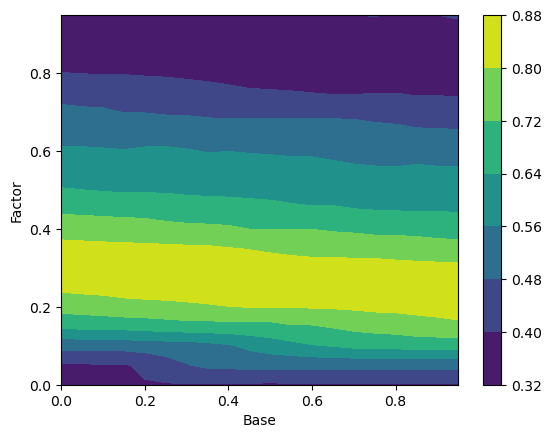

In [11]:
x,y = np.meshgrid(base_arr,factor_arr)

plt.contourf(x.T,y.T,corr_arr)
plt.colorbar()
plt.ylabel('Factor')
plt.xlabel('Base')

In [12]:
i_base_haro,i_factor_haro = np.where(corr_arr==np.max(corr_arr))

base_haro = base_arr[i_base_haro]
factor_haro = factor_arr[i_factor_haro]

print(base_arr[i_base_haro],factor_arr[i_factor_haro])

[0.6] [0.25]


In [13]:
VStoPR_haro_sh = shift_time(VStoPR_haro,age_2018['forVStoPR_haro'][6],datelist_vs,base_haro[0],factor_haro[0])
VStoPR_harob_sh = shift_time(VStoPR_harob,age_2018['backVStoPR_haro'][6],datelist_vs,-base_haro[0],-factor_haro[0])

VStoPR_haro_m,VStoPR_harob_m,c2,VStoPR_haro_avg = merge(VStoPR_haro_sh,VStoPR_harob_sh)
print(c2)


0.8492671517907842


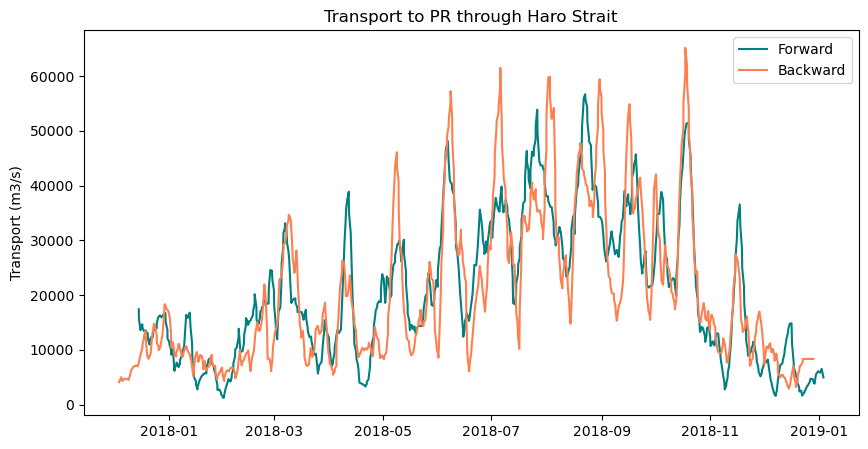

In [14]:
fig,ax = plt.subplots(1,1,figsize=(10,5))

ax.plot(VStoPR_haro_m,color='teal',label='Forward')
ax.plot(VStoPR_harob_m,color='coral',label='Backward')
# ax.plot(VStoPR_haro_avg.dropna(),color='black',label='Average')
ax.set_ylabel('Transport (m3/s)')
ax.set_title('Transport to PR through Haro Strait')
ax.legend()

Look at correlations to see what they are. Check if this is now whats expected (since before with Haro it wasn't)

Look at surface

### Correlation with density difference

0.7525763591452195


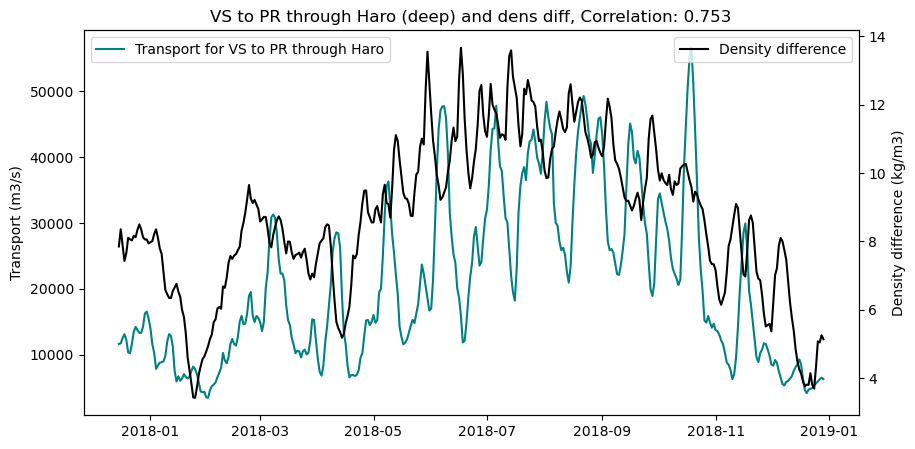

In [15]:
dateharo_sh = list(VStoPR_haro_avg.dropna().index)
mask = np.isin(datelist_dens,dateharo_sh)
densdiff_vs = dens_diff[mask]

datelist_VStoHaro_dens = np.array(datelist_dens)[mask]

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(VStoPR_haro_avg.dropna(),label='Transport for VS to PR through Haro',color='teal')
ax2 = ax.twinx()
ax2.plot(datelist_VStoHaro_dens,densdiff_vs,color='k',label='Density difference')
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Density difference (kg/m3)')
ax.legend()
ax2.legend()

corr_VStoHaro_dens,pvalue = stats.spearmanr(VStoPR_haro_avg.dropna(),densdiff_vs)
ax.set_title(f'VS to PR through Haro (deep) and dens diff, Correlation: {np.round(corr_VStoHaro_dens,3)}')
print(corr_VStoHaro_dens)

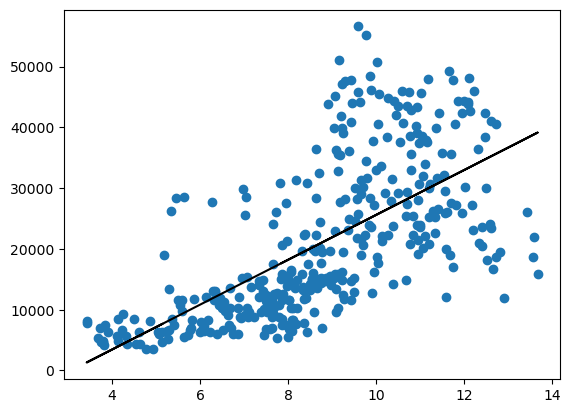

In [16]:
slope,intercept = np.polyfit(densdiff_vs,VStoPR_haro_avg.dropna(),1)
ddline_haro = slope*densdiff_vs+intercept
res_haro = VStoPR_haro_avg.dropna()-ddline_haro

plt.scatter(densdiff_vs,VStoPR_haro_avg.dropna())
plt.plot(densdiff_vs,ddline_haro,color='k')


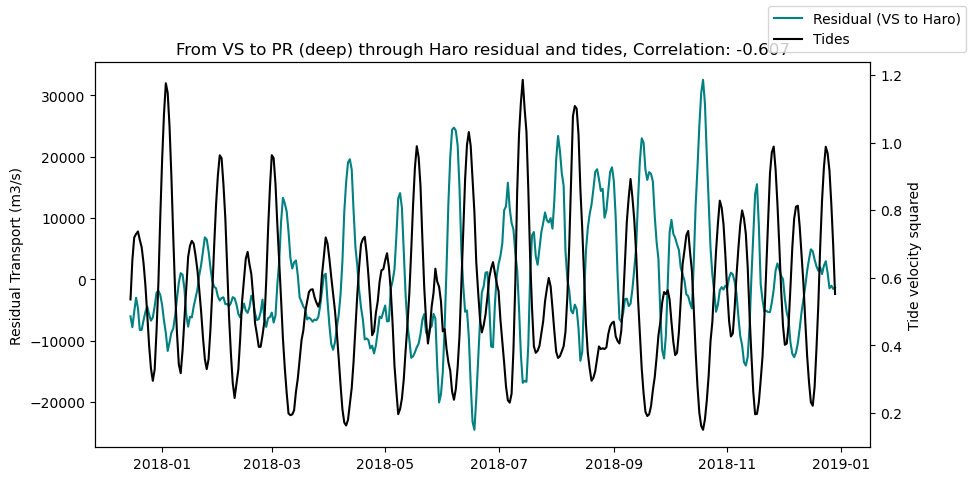

In [17]:
mask2 = np.isin(datelist_tides,dateharo_sh)

tides_vs = tides.vozocrtx[mask2]

corr_VStoPR_harod_tides,pvalue = stats.spearmanr(tides_vs,res_haro)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(res_haro,color='teal',label='Residual (VS to Haro)')
ax2=ax.twinx()
ax2.plot(dateharo_sh,tides_vs,color='k',label='Tides')
ax.set_title(f'From VS to PR (deep) through Haro residual and tides, Correlation: {np.round(corr_VStoPR_harod_tides,3)}')
ax.set_ylabel('Residual Transport (m3/s)')
ax2.set_ylabel('Tide velocity squared')
fig.legend()

#### Variance explained

In [18]:
var_dd = (np.corrcoef(densdiff_vs,VStoPR_haro_avg.dropna())[0,1])**2
print(var_dd)

(np.corrcoef(tides_vs,res_haro)[0,1])**2


0.4301476308855913


0.3682722003392652

### From PR to VS 

In [19]:
PRtoVS_harol = sectransp_2018['forPR_haro'][6]
PRtoVS_harobl = sectransp_2018['backvs_haro'][6]

PRtoVS_haro = pd.Series(PRtoVS_harol,index=datelist_vs)
PRtoVS_harob = pd.Series(PRtoVS_harobl,index=datelist_vs)

In [20]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(0,1,0.05)
base_arr = np.arange(0,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtoVS_haro,age_2018['forPR_haro'][6],datelist_vs,base,factor)
        dfr2 = shift_time(PRtoVS_harob,age_2018['backvs_haro'][6],datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.67:
            print (base, factor, corr_arr[i, j])

0.0 0.2 0.6749250454751264
0.05 0.2 0.6726657016946778
0.1 0.2 0.6756417219227652
0.25 0.15000000000000002 0.6705097850292377
0.30000000000000004 0.15000000000000002 0.6768011865322533
0.35000000000000003 0.15000000000000002 0.6772015679060842
0.4 0.15000000000000002 0.6865279647961294
0.45 0.15000000000000002 0.6806302124298468
0.5 0.15000000000000002 0.6739565939615609
0.55 0.15000000000000002 0.6763063266797451
0.8500000000000001 0.1 0.6761427660587097
0.9 0.1 0.6772015679060842
0.9500000000000001 0.1 0.6838382753350383


Text(0.5, 0, 'Base')

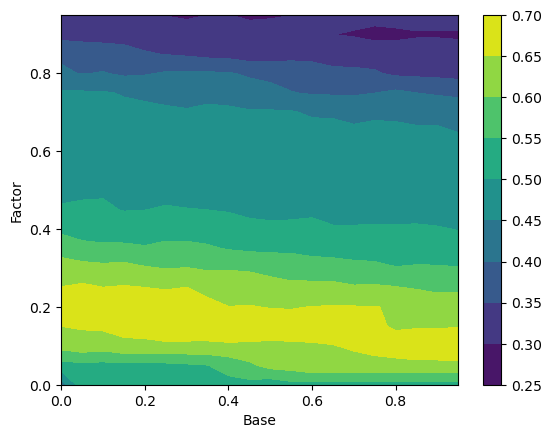

In [21]:
x,y = np.meshgrid(base_arr,factor_arr)

plt.contourf(x.T,y.T,corr_arr)
plt.colorbar()
plt.ylabel('Factor')
plt.xlabel('Base')

In [22]:
i_base_haro,i_factor_haro = np.where(corr_arr==np.max(corr_arr))

base_haro = base_arr[i_base_haro]
factor_haro = factor_arr[i_factor_haro]

print(base_arr[i_base_haro],factor_arr[i_factor_haro])

[0.4] [0.15]


In [23]:
PRtoVS_haro_sh = shift_time(PRtoVS_haro,age_2018['forPR_haro'][6],datelist_vs,base_haro[0],factor_haro[0])
PRtoVS_harob_sh = shift_time(PRtoVS_harob,age_2018['backvs_haro'][6],datelist_vs,-base_haro[0],-factor_haro[0])

PRtoVS_haro_m,PRtoVS_harob_m,c2,PRtoVS_haro_avg = merge(PRtoVS_haro_sh,PRtoVS_harob_sh)
print(c2)

0.6865279647961294


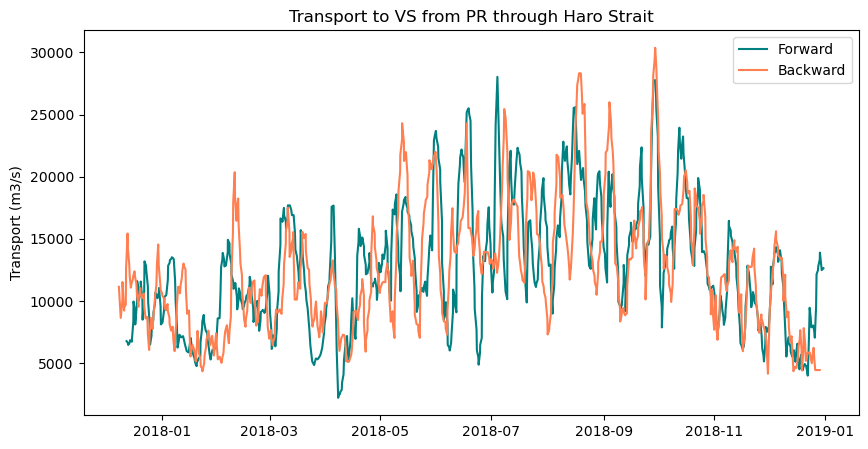

In [24]:
fig,ax = plt.subplots(1,1,figsize=(10,5))

ax.plot(PRtoVS_haro_m,color='teal',label='Forward')
ax.plot(PRtoVS_harob_m,color='coral',label='Backward')
# ax.plot(PRtoVS_haro_avg.dropna(),color='black',label='Average')
ax.set_ylabel('Transport (m3/s)')
ax.set_title('Transport to VS from PR through Haro Strait')
ax.legend()

### Correlation with density difference

0.7525763591452195


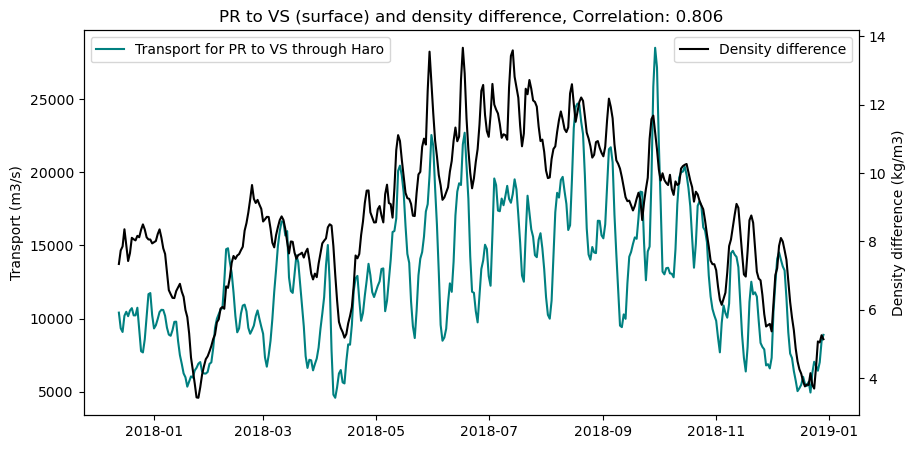

In [25]:
dateharopr_sh = list(PRtoVS_haro_avg.dropna().index)
mask = np.isin(datelist_dens,dateharopr_sh)
densdiff_vs = dens_diff[mask]

datelist_PRtoVS_haro_dens = np.array(datelist_dens)[mask]

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(PRtoVS_haro_avg.dropna(),label='Transport for PR to VS through Haro',color='teal')
ax2 = ax.twinx()
ax2.plot(datelist_PRtoVS_haro_dens,densdiff_vs,color='k',label='Density difference')
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Density difference (kg/m3)')
ax.legend()
ax2.legend()

corr_PRtoVS_haro_dens,pvalue = stats.spearmanr(PRtoVS_haro_avg.dropna(),densdiff_vs)
ax.set_title(f'PR to VS (surface) and density difference, Correlation: {np.round(corr_PRtoVS_haro_dens,3)}')
print(corr_VStoHaro_dens)

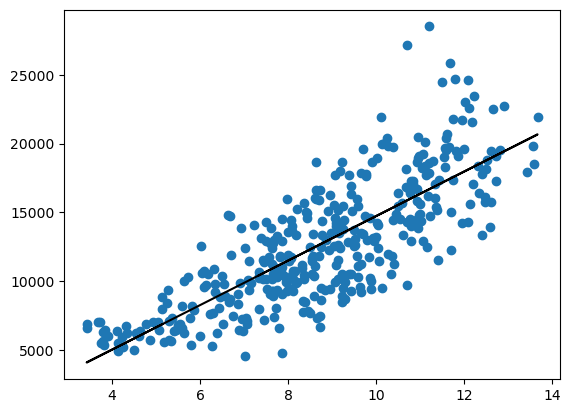

In [26]:
slope,intercept = np.polyfit(densdiff_vs,PRtoVS_haro_avg.dropna(),1)
ddline_haro = slope*densdiff_vs+intercept
res_haro = PRtoVS_haro_avg.dropna()-ddline_haro

plt.scatter(densdiff_vs,PRtoVS_haro_avg.dropna())
plt.plot(densdiff_vs,ddline_haro,color='k')

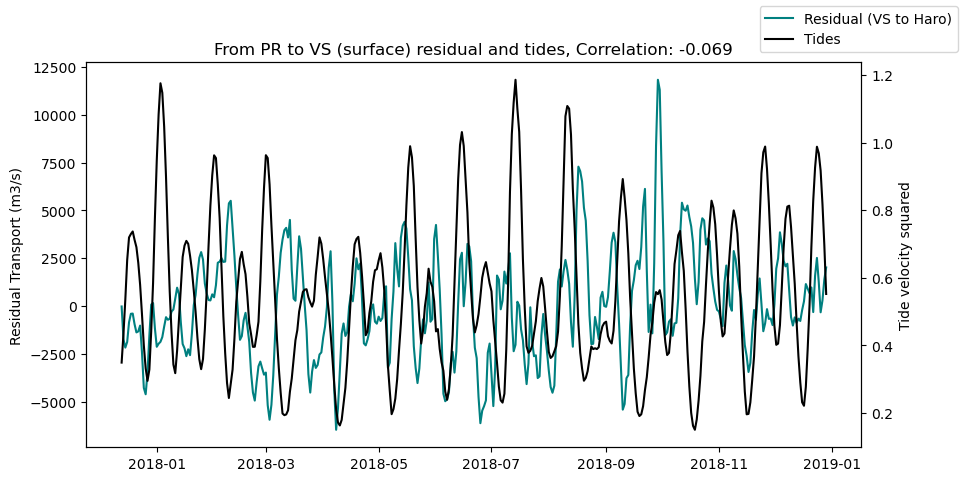

In [27]:
mask2 = np.isin(datelist_tides,dateharopr_sh)

tides_vs = tides.vozocrtx[mask2]

corr_PRtoVS_haro_tides,pvalue = stats.spearmanr(tides_vs,res_haro)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(res_haro,color='teal',label='Residual (VS to Haro)')
ax2=ax.twinx()
ax2.plot(dateharopr_sh,tides_vs,color='k',label='Tides')
ax.set_title(f'From PR to VS (surface) residual and tides, Correlation: {np.round(corr_PRtoVS_haro_tides,3)}')
ax.set_ylabel('Residual Transport (m3/s)')
ax2.set_ylabel('Tide velocity squared')
fig.legend()

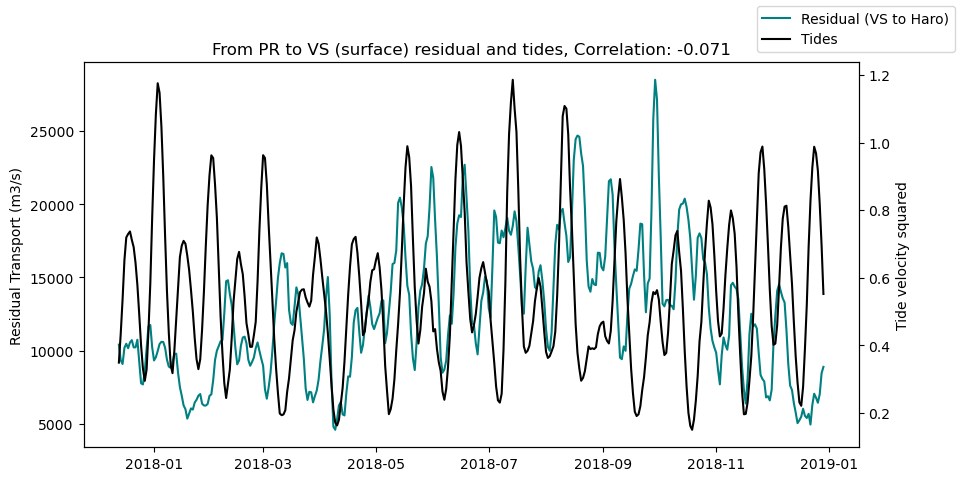

In [28]:
mask2 = np.isin(datelist_tides,dateharopr_sh)

tides_vs = tides.vozocrtx[mask2]

corr_PRtoVS_haro_tides,pvalue = stats.spearmanr(tides_vs,PRtoVS_haro_avg.dropna())

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(PRtoVS_haro_avg.dropna(),color='teal',label='Residual (VS to Haro)')
ax2=ax.twinx()
ax2.plot(dateharopr_sh,tides_vs,color='k',label='Tides')
ax.set_title(f'From PR to VS (surface) residual and tides, Correlation: {np.round(corr_PRtoVS_haro_tides,3)}')
ax.set_ylabel('Residual Transport (m3/s)')
ax2.set_ylabel('Tide velocity squared')
fig.legend()

Text(0, 0.5, 'Density difference (kg/m3)')

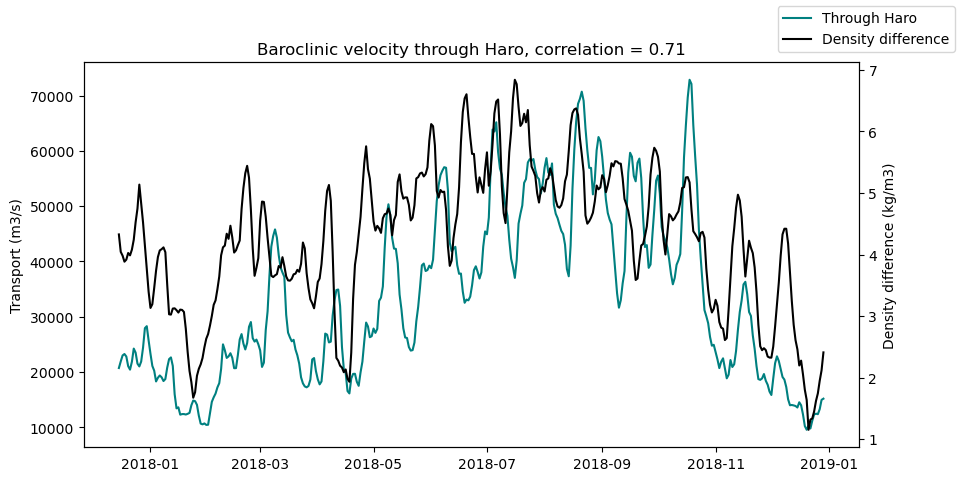

In [29]:
VSPR_haro_bclin = (VStoPR_haro_avg.dropna() + PRtoVS_haro_avg.dropna()).dropna()

date_haro_bclin = list(VSPR_haro_bclin.index)
mask = np.isin(datelist_dens,date_haro_bclin)
densdiff_haro_bclin = dens_diff_haro[mask]

corr_haro_bclin,p = stats.spearmanr(densdiff_haro_bclin,VSPR_haro_bclin)

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(VSPR_haro_bclin,label='Through Haro',color='teal')
ax2 = ax.twinx()
ax2.plot(np.array(datelist_dens)[mask],densdiff_haro_bclin,label='Density difference',color='k')
ax.set_title(f'Baroclinic velocity through Haro, correlation = {np.round(corr_haro_bclin,2)}')
fig.legend()
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Density difference (kg/m3)')

Text(0, 0.5, 'Tide velocity squared')

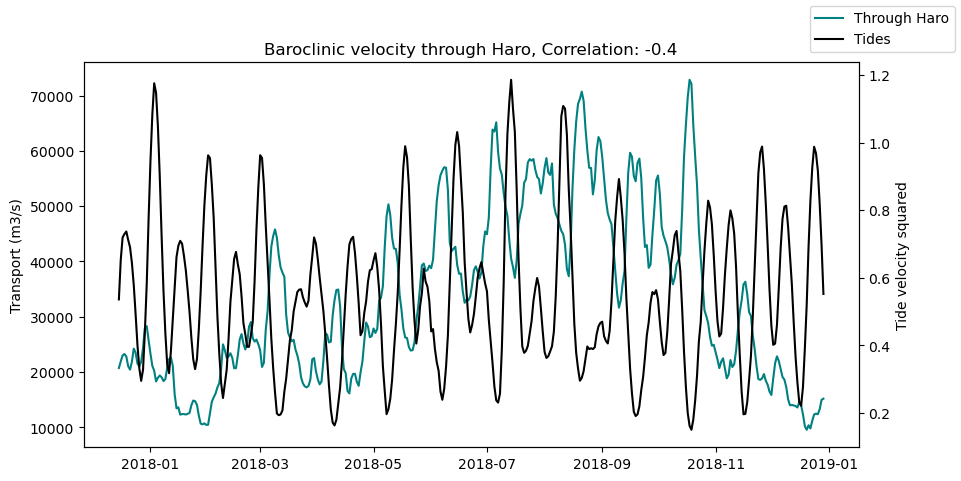

In [30]:
mask = np.isin(datelist_tides,date_haro_bclin)
tides_haro_bclin = tides.vozocrtx[mask]

corr_haro_bclin_tides,p = stats.spearmanr(tides_haro_bclin,VSPR_haro_bclin)

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(VSPR_haro_bclin,color='teal',label='Through Haro')
ax2 = ax.twinx()
ax2.plot(np.array(datelist_tides)[mask],tides_haro_bclin,color='k',label='Tides')
ax.set_title(f'Baroclinic velocity through Haro, Correlation: {np.round(corr_haro_bclin_tides,2)}')
fig.legend()
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Tide velocity squared')

#### Correlation of residual with tides

Text(0, 0.5, 'Tide velocity squared')

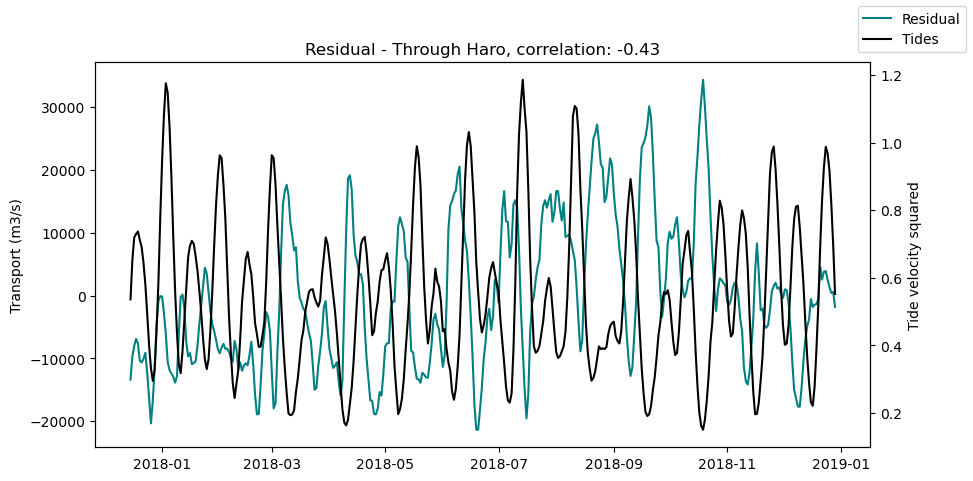

In [31]:
slope,intercept = np.polyfit(densdiff_haro_bclin,VSPR_haro_bclin,1)
ddline = slope*densdiff_haro_bclin+intercept

res_haro_bclin = VSPR_haro_bclin - ddline

corr_haro_res_tides,p = stats.spearmanr(tides_haro_bclin,res_haro_bclin)

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(res_haro_bclin,color='teal',label='Residual')
ax2 = ax.twinx()
ax2.plot(np.array(datelist_tides)[mask],tides_haro_bclin,label='Tides',color='k')
fig.legend()
ax.set_title(f'Residual - Through Haro, correlation: {np.round(corr_haro_res_tides,2)}');
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Tide velocity squared')

In [32]:
var_dd = (np.corrcoef(densdiff_haro_bclin,VSPR_haro_bclin)[0,1])**2
print(var_dd)

var_tides = (np.corrcoef(tides_haro_bclin,res_haro_bclin)[0,-1])**2
print(var_tides)

0.44886572898482274
0.19199205511662434


### Correlation to admiralty

In [33]:
# PRtoVS_harol = sectransp_2018['forPR_haro'][6]
# PRtoVS_harobl = sectransp_2018['backpr_haro'][6]

# PRtoVS_haro = pd.Series(PRtoVS_harol,index=datelist_vs)
# PRtoVS_harob = pd.Series(PRtoVS_harobl,index=datelist_vs)

Can't do this correlation until backadm_haro has been done -> Do this run 

First look at different boundary configurations at Admiralty

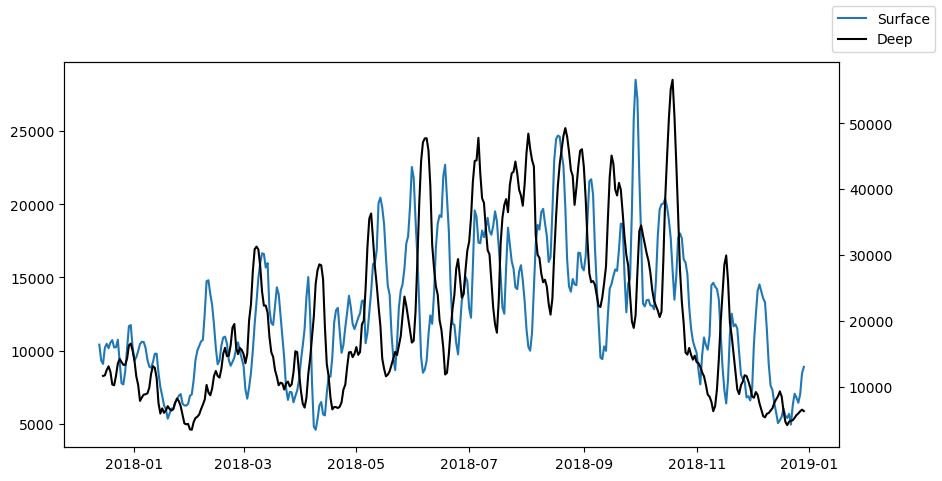

In [34]:
fig,ax = plt.subplots(figsize=(10,5))

ax.plot(PRtoVS_haro_avg.dropna(),label='Surface')
# ax.plot(VStoPR_haro_avg.dropna(),label='Deep')
ax2 = ax.twinx()
ax2.plot(VStoPR_haro_avg.dropna(),label='Deep',color='k')
# ax2.plot(np.array(datelist_tides)[mask],tides_haro_bclin,color='k',label='Tides')
fig.legend()

### Look at age 

SignificanceResult(statistic=0.542143445932306, pvalue=8.488963918013272e-31)


Text(0, 0.5, 'Age (hours)')

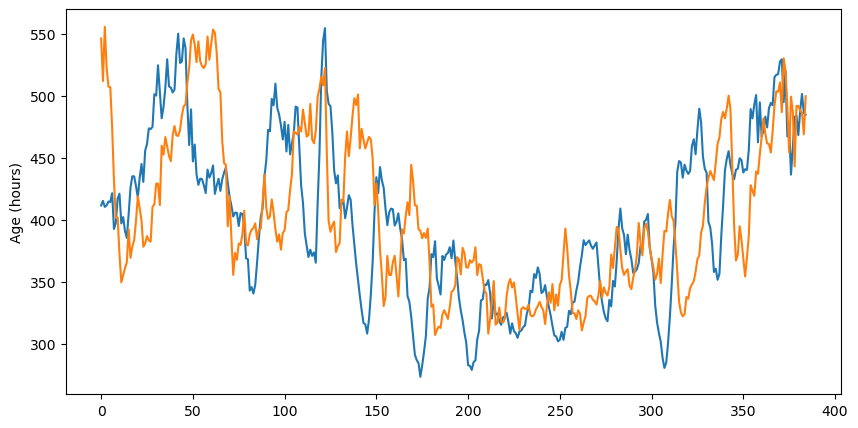

In [35]:
a1 = age_2018['forVStoPR_haro'][6]
a2 = age_2018['backVStoPR_haro'][6]


print(stats.spearmanr(a1,a2))

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(a1,label='Forward')
ax.plot(a2,label='Backwards')
ax.set_ylabel('Age (hours)')

SignificanceResult(statistic=0.6038035798398492, pvalue=1.298785907385908e-39)


Text(0, 0.5, 'Age (hours)')

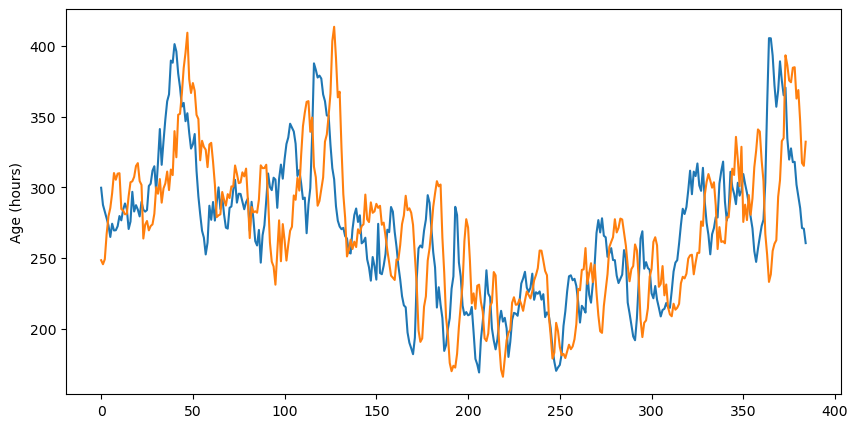

In [36]:
a1 = age_2018['forPR_haro'][6]
a2 = age_2018['backvs_haro'][6]


print(stats.spearmanr(a1,a2))

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(a1)
ax.plot(a2)
ax.set_ylabel('Age (hours)')

In [37]:
wind = pd.read_csv('../notebooks/day_avg_wind.csv')
x = wind['time']
y = wind['wind']

date = dt.datetime(2017,1,1)
enddate = dt.datetime(2019,12,31)
datelist_winds = []

while date <= enddate:
    datelist_winds.append(date)
    date+=dt.timedelta(days=1)
    
y_mean4 = y.rolling(window=4, center=True).mean()

In [38]:
print(wind.shape)
print(len(datelist_winds))

(1095, 2)
1095


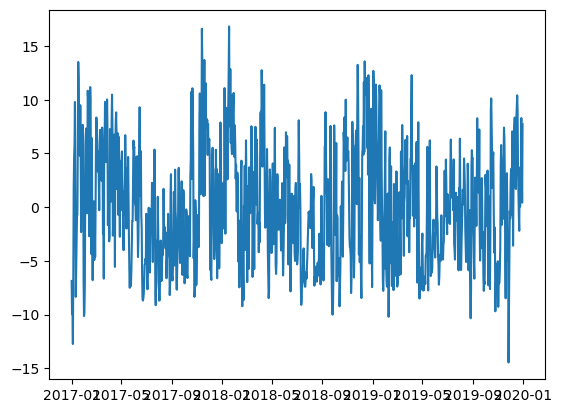

In [39]:
wind.set_index(pd.to_datetime(datelist_winds), inplace=True)
plt.plot(wind['wind'])

Text(0, 0.5, 'Wind velocity (m/s)')

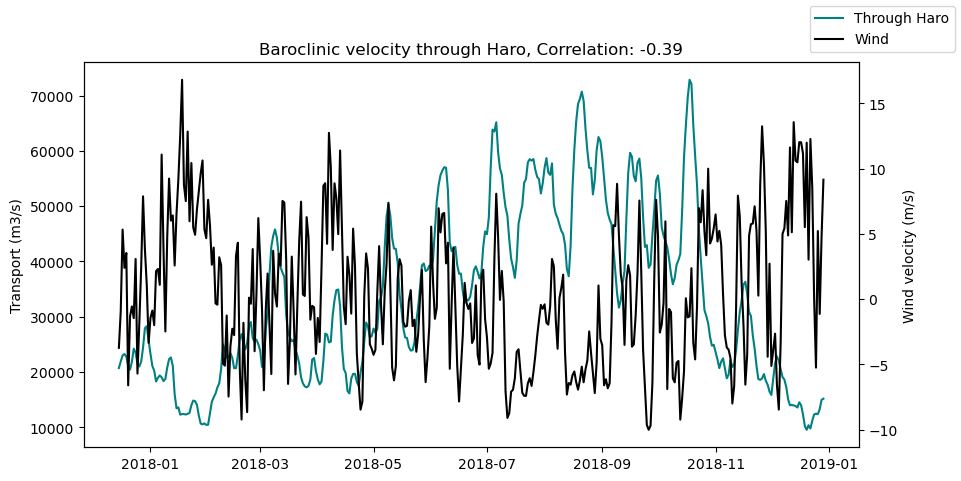

In [40]:
mask = np.isin(datelist_winds,date_haro_bclin)
wind_haro_bclin = wind.wind[mask]

corr_haro_bclin_wind,p = stats.spearmanr(wind_haro_bclin,VSPR_haro_bclin)
corr_haro_bclin_wind

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(VSPR_haro_bclin,color='teal',label='Through Haro')
ax2 = ax.twinx()
ax2.plot(wind_haro_bclin,color='k',label='Wind')
ax.set_title(f'Baroclinic velocity through Haro, Correlation: {np.round(corr_haro_bclin_wind,2)}')
fig.legend()
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Wind velocity (m/s)')

Look at the correlation with the density difference to see if that could be why its so high?

-0.3462711407104262


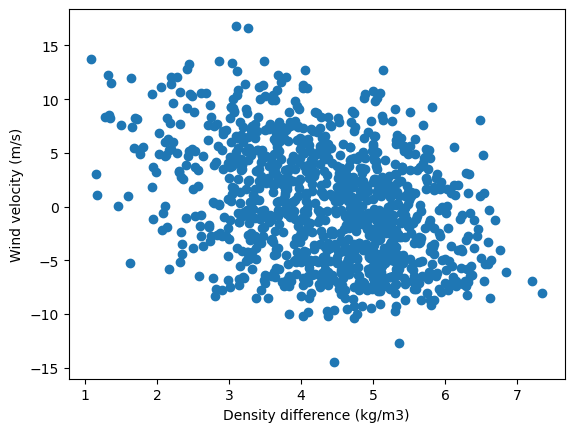

In [41]:
plt.scatter(dens_diff_haro,wind.wind)
corr_dd_wind,p = stats.spearmanr(dens_diff_haro,wind.wind)
print(corr_dd_wind)
plt.xlabel('Density difference (kg/m3)')
plt.ylabel('Wind velocity (m/s)');

Now plot with the residual from density difference

Text(0, 0.5, 'Transport ')

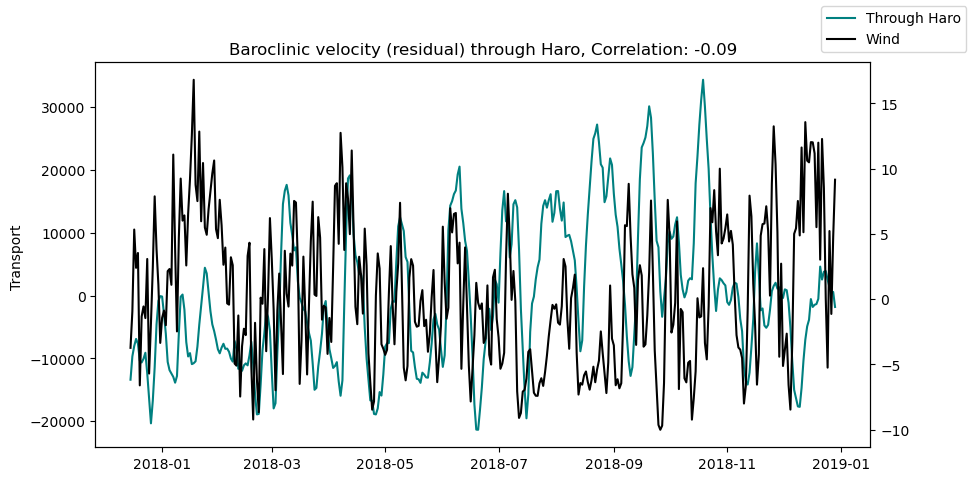

In [42]:
corr_res_wind,p = stats.spearmanr(wind_haro_bclin,res_haro_bclin)

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(res_haro_bclin,color='teal',label='Through Haro')
ax2 = ax.twinx()
ax2.plot(wind_haro_bclin,color='k',label='Wind')
ax.set_title(f'Baroclinic velocity (residual) through Haro, Correlation: {np.round(corr_res_wind,2)}')
fig.legend()
ax.set_ylabel('Transport ')

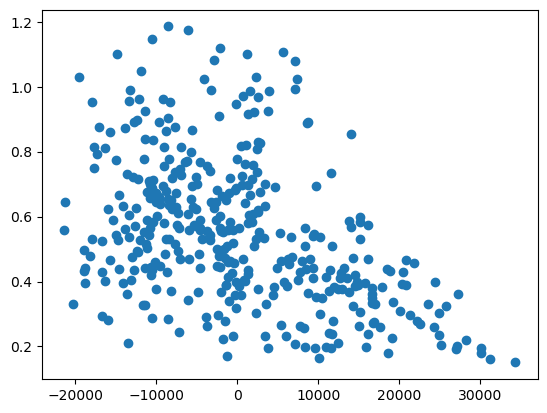

In [43]:
# plt.scatter(res_haro_bclin,wind_haro_bclin)
plt.scatter(res_haro_bclin,tides_haro_bclin)

Find residual after tides to look at wind

0.13530907234012773


Text(0, 0.5, 'Wind velocity (m/s)')

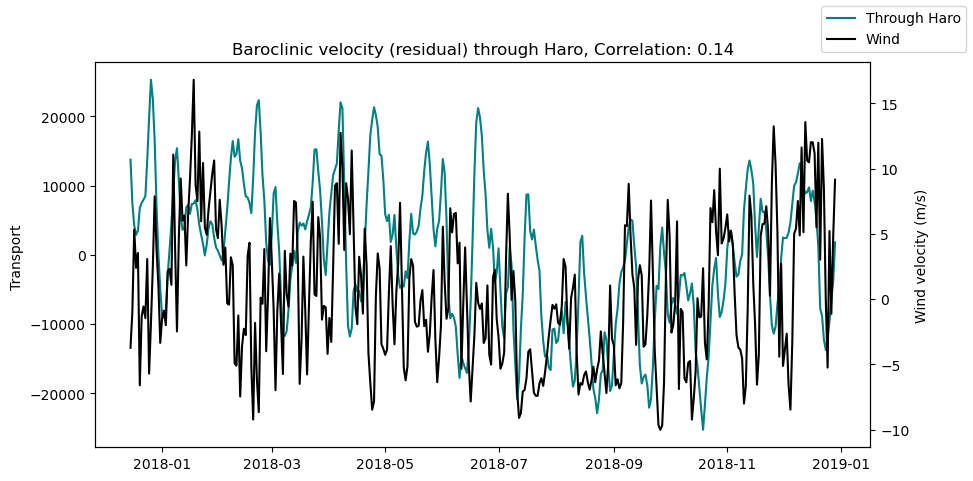

In [44]:
slope,intercept = np.polyfit(tides_haro_bclin,res_haro_bclin,1)
fit2_haro = slope*tides_haro_bclin+intercept
res2_haro = fit2_haro - res_haro_bclin.values

corr_res2_wind,p = stats.spearmanr(wind_haro_bclin,res2_haro)
print(corr_res2_wind)

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(date_haro_bclin,res2_haro,color='teal',label='Through Haro')
ax2 = ax.twinx()
ax2.plot(wind_haro_bclin,color='k',label='Wind')
ax.set_title(f'Baroclinic velocity (residual) through Haro, Correlation: {np.round(corr_res2_wind,2)}')
fig.legend()
ax.set_ylabel('Transport ')
ax2.set_ylabel('Wind velocity (m/s)')

Text(0, 0.5, 'Residual Transport (m3/s)')

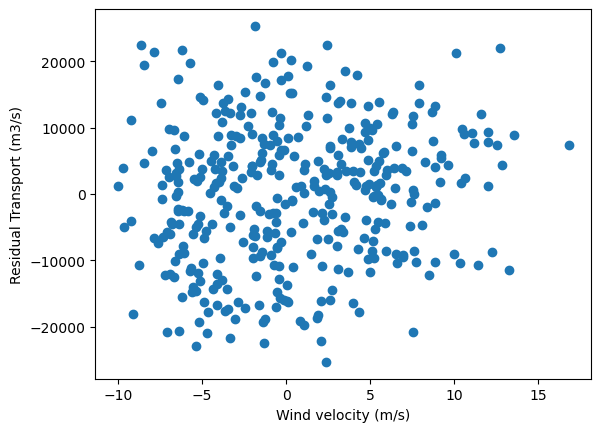

In [45]:
plt.scatter(wind_haro_bclin,res2_haro)
plt.xlabel('Wind velocity (m/s)')
plt.ylabel('Residual Transport (m3/s)')